In [1]:
USE_GRID_SEARCH = False

import sys
!{sys.executable} -m pip install --upgrade pip
!{sys.executable} -m pip install langdetect

Requirement already up-to-date: pip in c:\users\apavelic\appdata\local\continuum\anaconda3\lib\site-packages (19.0.3)


In [2]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot
import time

# Loading the data

In [3]:
with open('movies.json', 'r') as f:
    data = json.load(f)

In [4]:
pd.DataFrame(data)

,1,2,3,4,5,6,7,8,9,10,...,9759,9760,9761,9762,9763,9764,9765,9766,9767,9768
genres,"[Action, Crime, Drama, Sport]","[Adventure, Drama, Family, War]","[Adventure, Comedy, Family]","[Comedy, Drama, Musical]","[Comedy, Romance]","[Action, Adventure, Comedy]","[Adventure, Family, Fantasy]","[Comedy, Drama, Romance]","[Crime, Drama, Thriller]","[Action, Thriller]",...,"[Action, Comedy, Crime, Drama]","[Action, Adventure, Comedy, Drama, Family, War]","[Action, Crime, Drama, Thriller]",[Documentary],"[Comedy, Drama, Romance]","[Action, Adventure, Thriller]","[Animation, Adventure, Comedy, Family, Western]","[Action, Horror, Sci-Fi, Thriller]","[Biography, Drama, Sport]","[Action, Crime, Mystery, Thriller]"
plots,"[George ""Ice Man"" Chambers (Rhames) is a top r...",[Laddie (Son of Lassie !) and his master are t...,[A take on the classic tale 'The Boy Who Cried...,[A developer tries to bulldoze a community rec...,[Lily and Dan are a couple who have been divor...,[After his brother Robeson disappears without ...,"[Alice, an unpretentious and individual 19-yea...","[In Spokane, Washington, Juniper Pearl - Joon ...",[Terry Malloy dreams about being a prize fight...,[Matteo Juarez is a retired detective hired by...,...,[Charlie and his troublesome cousin Paulie dec...,"[During the Vietnam War, a village that Americ...",[Tom Sharky is a narcotics cop in Atlanta who'...,"[Thirty years, three generations, and a lifeti...",[This story based on the best selling novel by...,[James Bond is on possibly his most brutal mis...,[Rango is a pet chameleon always on the lookou...,[LAPD lieutenant Mike Harrigan (Danny Glover) ...,[It's the post-WWI era. Britons Harold Abraham...,[Evelyn Salt is a CIA agent and highly respect...


## Matrix transponse for better manipulation

In [5]:
df_start = pd.DataFrame(data).T
df_start.shape

(9768, 2)

In [6]:
df_start.head()

,genres,plots
1,"[Action, Crime, Drama, Sport]","[George ""Ice Man"" Chambers (Rhames) is a top r..."
2,"[Adventure, Drama, Family, War]",[Laddie (Son of Lassie !) and his master are t...
3,"[Adventure, Comedy, Family]",[A take on the classic tale 'The Boy Who Cried...
4,"[Comedy, Drama, Musical]",[A developer tries to bulldoze a community rec...
5,"[Comedy, Romance]",[Lily and Dan are a couple who have been divor...


## Helper functions
Functions for preprocessing

In [7]:
from langdetect import detect
from sklearn.preprocessing import MultiLabelBinarizer

def has_missing(data):
    """
    Function which tell if missing values exit

    :param data: list of values        
    :return: bit
    """
    for row in data:
        X = pd.DataFrame(row)
        
        if (X.isnull().values.any()):
            return True
        
        for string in row:
            if string.strip()=="":
                return True
            
    return False

def get_unique_genres(all_genres):
    """
    Function that find unique values

    :param all_genres: list of all genres   
    :return: list of strings (unique genres)
    """
    unique_genres = set()
    for movie_genre in all_genres:
        unique_genres = unique_genres.union(movie_genre)
    return list(unique_genres)

def create_dummy_variables_for_genres(df, unique_genres):
    """
    Creates dummy variables of genres on the given DataFrame. All dummy variables are binary

    :param df: DataFrame
    :param unique_genres: list of strings (unique values)
    """
    labelizer = MultiLabelBinarizer(unique_genres)
    biniray_labels = labelizer.fit_transform(df.genres)
    _data = pd.DataFrame(biniray_labels, columns=labelizer.classes)
    
    newdf = pd.concat([df.reset_index(), _data.reset_index()], axis=1)
    newdf.drop(['index'], axis=1, inplace=True)
    
    return newdf

def remove_duplicates(df):
    """
    Removes duplicates on the given data frame

    :param df: DataFrame
    """
    for index, plots in enumerate(df['plots']):
        without_duplicates = set(plots)
        if len(plots)!=len(without_duplicates):
            df['plots'].iloc[index] = list(without_duplicates)  

def prepare_data(df, unique_genres, only_english_plots=False):
    """
    Preparing the data for prediction model

    :param df: DatFrame
    :param unique_genres: list of strings, unique genres  
    :param create_dummies: bit         
    :return: list of strings (keywords)
    """
    remove_duplicates(df)
    
    new_rows = []

    for index, row in df.iterrows():
        genres = row['genres']

        for plot in row["plots"]:
            new_row = {}
            new_row['genres'] = genres 
            new_row['plot'] = plot
            new_rows.append(new_row)
            
    newdf = pd.DataFrame(new_rows)
    newdf = create_dummy_variables_for_genres(newdf, unique_genres)
        
    if only_english_plots:
        newdf['language'] = newdf.apply(lambda row: detect(row['plot']), axis=1)

        print('All plots:', newdf.shape)
        newdf = newdf[newdf.language.isin(['en'])]
        print('English plots:', newdf.shape)

        del newdf['language']
    
    return newdf

def get_stats(df):
    """
    Get simple statistics for given data

    :param df: DataFrame     
    :return: DataFrame, represents stats (genre with number of plots)
    """
    df_genres = df.drop(['plot', 'genres'], axis=1)
    counts = []
    categories = list(df_genres.columns.values)
    for i in categories:
        counts.append((i, df_genres[i].sum()))
    return pd.DataFrame(counts, columns=['genre', 'movies'])
    

# Data introduction

Find missing values or empty strings

In [8]:
for col in df_start.columns:
    if has_missing(df_start[col]):
        print(f'{col} - missing values exist')
        continue
    print(f'{col} - missing values do not exit')


genres - missing values do not exit
plots - missing values do not exit


In [9]:
unique_genres = get_unique_genres(df_start.genres)
print(unique_genres)

['Adventure', 'Family', 'News', 'Action', 'Comedy', 'Documentary', 'Thriller', 'Musical', 'Biography', 'War', 'Crime', 'Animation', 'Sci-Fi', 'History', 'test2', 'Sport', 'Horror', 'Western', 'test1', 'Romance', 'Music', 'Short', 'Drama', 'Mystery', 'test3', 'Fantasy', 'Film-Noir']


#### As we see, we have some "fake" genres (test1, test2 and test3) and some of them are not movies genres (News, Short)

Some of rows have some other genres with these fake genres. So, we won't remove every row which exists fake genre. We want remove only fake genre from all other genres whithin row. For example: if in row exists Comedy, Drama, Short - we will remove only Short genre from that list

## Data prepartaion

- We will remove duplicates
- We will extend each plot for all of genres within that row
- We will add binary column for each genre
- We will include only plots on english language

In [10]:
df = prepare_data(df_start, unique_genres, only_english_plots=True)

All plots: (28169, 30)
English plots: (28140, 30)


Splitting bad data (with fake genres) and good data

In [11]:
bad_genres = list(filter(lambda x: 'test' in x, unique_genres))
unique_genres = [x for x in unique_genres if x not in bad_genres]

In [12]:
df_bad_test = df[df.genres.apply(lambda movie_genres: any(bad_genre in bad_genres for bad_genre in movie_genres))]
get_unique_genres(df_bad_test.genres)

['test3', 'test1', 'test2']

In [13]:
df_bad_news = df[df.genres.apply(lambda movie_genres: any(bad_genre == 'News' for bad_genre in movie_genres))]
get_unique_genres(df_bad_news.genres)

['News',
 'Drama',
 'Documentary',
 'Biography',
 'Thriller',
 'Mystery',
 'Crime',
 'History']

In [14]:
df_bad_short = df[df.genres.apply(lambda movie_genres: any(bad_genre == 'Short' for bad_genre in movie_genres))]
get_unique_genres(df_bad_short.genres)

['Adventure',
 'Family',
 'Action',
 'Comedy',
 'Documentary',
 'Biography',
 'Musical',
 'Thriller',
 'War',
 'Crime',
 'Animation',
 'Sci-Fi',
 'History',
 'Sport',
 'Horror',
 'Western',
 'Music',
 'Short',
 'Romance',
 'Drama',
 'Mystery',
 'Fantasy']

In [15]:
df_clean = df.drop(df_bad_test.index, inplace=False)

In [16]:
df_clean.drop(bad_genres + ['News', 'Short'], axis=1, inplace=True)

In [17]:
df_clean.head()

,genres,plot,Adventure,Family,Action,Comedy,Documentary,Thriller,Musical,Biography,...,History,Sport,Horror,Western,Romance,Music,Drama,Mystery,Fantasy,Film-Noir
0,"[Action, Crime, Drama, Sport]","George ""Ice Man"" Chambers (Rhames) is a top ra...",0,0,1,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
1,"[Action, Crime, Drama, Sport]",Monroe Hutchens is the heavyweight champion of...,0,0,1,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
2,"[Action, Crime, Drama, Sport]","When heavyweight champion George ""Iceman"" Cham...",0,0,1,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
3,"[Adventure, Drama, Family, War]",Laddie (Son of Lassie !) and his master are tr...,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,"[Adventure, Comedy, Family]",A take on the classic tale 'The Boy Who Cried ...,1,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [18]:
df_bad_test = df_bad_test[['genres', 'plot']]
df_bad_test.shape

(3515, 2)

Check if row doesn't exist any genres and then remove (if exists)

In [19]:
(df_clean.drop(['genres', 'plot'], axis=1).mean(axis=1) == 0).any()

True

In [20]:
df_clean['empty'] = 0
df_clean['empty'] = df_clean.drop(['empty', 'genres', 'plot'], axis=1).mean(axis=1)

without_genres = df_clean[df_clean['empty']==0]
without_genres.head()

,genres,plot,Adventure,Family,Action,Comedy,Documentary,Thriller,Musical,Biography,...,Sport,Horror,Western,Romance,Music,Drama,Mystery,Fantasy,Film-Noir,empty
11717,[Short],Another dazzling suburban phantasm from writer...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
12904,[Short],"Travel with the pint-sized supersleuths, Mary-...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
25161,[Short],A woman dressed elegantly walks purposely thro...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0


In [21]:
df_bad_test = df_bad_test.append(without_genres[['genres', 'plot']])
df_bad_test.tail()

,genres,plot
26661,[test2],Pedophile serial killer rapes and murders mult...
26662,[test2],Centers on a young girl who has been murdered ...
11717,[Short],Another dazzling suburban phantasm from writer...
12904,[Short],"Travel with the pint-sized supersleuths, Mary-..."
25161,[Short],A woman dressed elegantly walks purposely thro...


In [22]:
df_clean = df_clean[df_clean['empty']!=0]
del df_clean['empty']

In [23]:
(df_clean.drop(['genres', 'plot'], axis=1).mean(axis=1) == 0).any()

False

### Genre statistics

In [24]:
df_stats = get_stats(df_clean)
df_stats

,genre,movies
0,Adventure,4352
1,Family,2571
2,Action,4904
3,Comedy,9191
4,Documentary,873
5,Thriller,6835
6,Musical,905
7,Biography,1488
8,War,1157
9,Crime,4435


In [25]:
df_clean.tail()

,genres,plot,Adventure,Family,Action,Comedy,Documentary,Thriller,Musical,Biography,...,History,Sport,Horror,Western,Romance,Music,Drama,Mystery,Fantasy,Film-Noir
28164,"[Action, Crime, Mystery, Thriller]",Evelyn Salt is a CIA agent and highly respecte...,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
28165,"[Action, Crime, Mystery, Thriller]",A Russian calling himself Orlov and claiming t...,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
28166,"[Action, Crime, Mystery, Thriller]","As a CIA officer, Evelyn Salt swore an oath to...",0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
28167,"[Action, Crime, Mystery, Thriller]","Two years ago, the CIA field agent Evelyn Salt...",0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
28168,"[Action, Crime, Mystery, Thriller]",A CIA agent goes on the run after a defector a...,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0


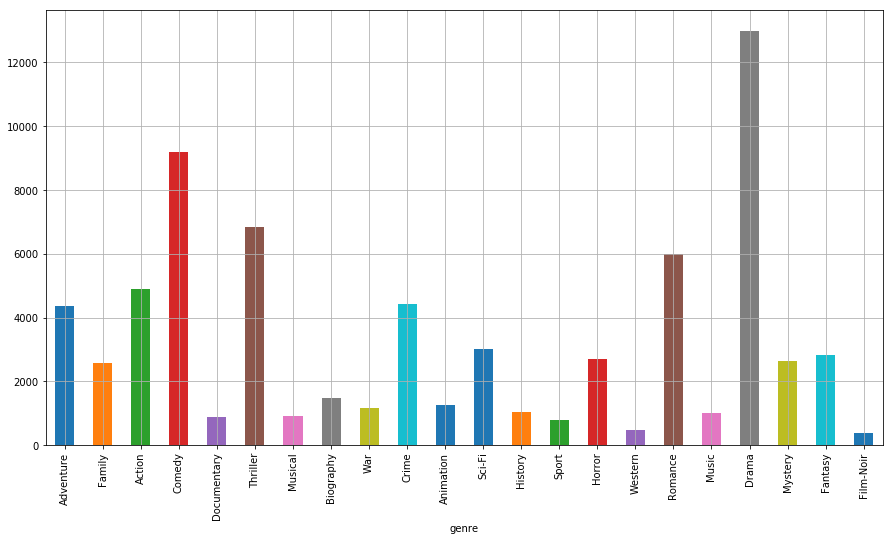

In [26]:
df_stats.plot(x='genre', y='movies', kind='bar', legend=False, grid=True, figsize=(15, 8))

In [27]:
df_clean_copy = df_clean.copy()
del df_clean['genres']
df_clean.head()

,plot,Adventure,Family,Action,Comedy,Documentary,Thriller,Musical,Biography,War,...,History,Sport,Horror,Western,Romance,Music,Drama,Mystery,Fantasy,Film-Noir
0,"George ""Ice Man"" Chambers (Rhames) is a top ra...",0,0,1,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
1,Monroe Hutchens is the heavyweight champion of...,0,0,1,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
2,"When heavyweight champion George ""Iceman"" Cham...",0,0,1,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
3,Laddie (Son of Lassie !) and his master are tr...,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
4,A take on the classic tale 'The Boy Who Cried ...,1,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## GenreClassifier
Helper class for prediction. For this purpose only LogisticRegression, LinerarSVC and MultinomialNB will be use. Ensamble is a good choice for that, but it won't be used because of computational power.

In [28]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from sklearn.preprocessing import normalize
from sklearn.decomposition import TruncatedSVD
from sklearn.naive_bayes import MultinomialNB
from nltk.tokenize import TweetTokenizer
from sklearn.pipeline import Pipeline
from snowballstemmer import stemmer
from sklearn.svm import LinearSVC
from nltk.corpus import stopwords
from string import punctuation
from functools import partial
import string
import nltk

class GenreClassifier(BaseEstimator, TransformerMixin):
    """
    Genre Classifier implemented by the capable hands of Algebra students.
    """
    def __init__(self, algorithm=None, tune_params = False):
        """
        Constructor
        
        :param algorithm: string, represents algorith that will be used in prediction model
        """
        nltk.download('punkt', quiet=True)
        nltk.download('stopwords', quiet=True)
        
        self.tune_params = tune_params
        self.algorithm = algorithm
        self.__initialize_tokenizer()
        
    def __initialize_tokenizer(self):
        """
        Function that initilize tokenizer and variables that used for tokenization.
        """
        stopwords_eng = set(stopwords.words("english"))
        stopwords_and_punctuation = stopwords_eng.union(punctuation)
        tweet_tokenizer = TweetTokenizer(preserve_case=False).tokenize
        eng_stemmer = stemmer("english")
        
        self.tokenizer = partial(self.__tokenize_and_stem,
                         tokenizer=tweet_tokenizer,
                         stopwords=stopwords_and_punctuation,
                         stemmer=eng_stemmer.stemWords)
    
    def __tokenize_and_stem(self, text, tokenizer, stopwords, stemmer):
        """
        Function that tokenizes, removes stopwords and stems input text.

        :param text: str, text to be tokenized.
        :param tokenizer: callable, separates text to list of word tokens.
        :param stemmer: callable, stems each word token.
        """
        text = text.lower()
        tokens = tokenizer(text)
        tokens = filter(lambda word: True if word not in stopwords else False, tokens)
        tokens = stemmer(tokens)
        return tokens
    
    def fit(self, X, y):
        """
        Function that train the model

        :param X: list of strings (plots)
        :param y: DataFrame matrix with genres (genres have to have binary values)
        """
        
        self.X = self.__remove_numbers(X)
        self.y = y
        self.y_columns = list(y.columns)
        self.svd = TruncatedSVD()        
        
        if self.tune_params:
            pipeline, params = self.__get_grid_search_params()
            kf = KFold(n_splits=5, random_state=10, shuffle=True)
            grid_search = GridSearchCV(pipeline, params, cv=kf, n_jobs=8)
            
            self.model = grid_search.fit(self.tfidf_output_train, self.y)            
            print(f'Best params given by GridSearchCV {self.model.best_params_}')
        else:
            pipeline = self.__get_pipeline()
            self.model = pipeline.fit(self.tfidf_output_train, self.y)
        
        return self.model
    
    def __get_grid_search_params(self):
        """
        Function that creates pipeline and params depends on algorithm
        """
        
        pipeline = None
        params = None
        
        if(self.algorithm == 'naive_bayes'):
            
            self.tfidf = TfidfVectorizer(lowercase=True, tokenizer=self.tokenizer, max_features=2000)    
            self.tfidf_output_train = self.tfidf.fit_transform(self.X)
            
            pipeline = Pipeline([('clf', OneVsRestClassifier(MultinomialNB(fit_prior=False, class_prior=None)))])
            params = { 'clf__estimator__alpha': np.array([0.0001, 0.001, 0.01, 0]) }
            
        elif(self.algorithm == 'linear_svc'):   
            
            self.tfidf = TfidfVectorizer(lowercase=True, tokenizer=self.tokenizer, max_features=10000)
            self.tfidf_output_train = self.tfidf.fit_transform(self.X)
            
            pipeline = Pipeline([
                ('svd', self.svd),
                ('clf', OneVsRestClassifier(LinearSVC()))
            ])
                      
            params = { 
                "svd__n_components": [300, 600, 800],
                "clf__estimator__C": [0.1, 1, 10],
                "clf__estimator__class_weight": ['balanced', None]
            }
                      
        elif(self.algorithm == None) | (self.algorithm == 'regression'):    
            
            self.tfidf = TfidfVectorizer(lowercase=True, tokenizer=self.tokenizer, max_features=10000)
            self.tfidf_output_train = self.tfidf.fit_transform(self.X)    
            
            pipeline = Pipeline([
                ('svd', self.svd),
                ('clf', OneVsRestClassifier(LogisticRegression()))
            ])
                      
            params = { 
                "svd__n_components": [300, 600, 800],
                "clf__estimator__C": [0.1, 1, 10],
                "clf__estimator__class_weight": ['balanced', None]
            }
                      
        return pipeline, params

    def __get_pipeline(self):
        """
        Function that creates pipeline with best parameters given by GridSearchCV
        """
        pipeline = None

        if(self.algorithm == 'naive_bayes'):    
            
            self.tfidf = TfidfVectorizer(lowercase=True, tokenizer=self.tokenizer, max_features=2000)
            self.tfidf_output_train = self.tfidf.fit_transform(self.X)    
            
            pipeline = Pipeline([('clf', OneVsRestClassifier(MultinomialNB(fit_prior=False, class_prior=None, alpha=0.0001)))])

        elif(self.algorithm == 'linear_svc'):    
            
            self.tfidf = TfidfVectorizer(lowercase=True, tokenizer=self.tokenizer, max_features=10000)
            self.tfidf_output_train = self.tfidf.fit_transform(self.X)
            
            pipeline = Pipeline([
                ('svd', TruncatedSVD(800)),
                ('clf', OneVsRestClassifier(LinearSVC(C=1, class_weight=None)))
            ])

        elif(self.algorithm == None) | (self.algorithm == 'regression'):    
            
            self.tfidf = TfidfVectorizer(lowercase=True, tokenizer=self.tokenizer, max_features=10000)
            self.tfidf_output_train = self.tfidf.fit_transform(self.X)
            
            pipeline = Pipeline([
                ('svd', TruncatedSVD(800)),
                ('clf', OneVsRestClassifier(LogisticRegression(C=10, class_weight=None)))
            ])

        return pipeline
                      
    
    def predict(self, X):
        """
        Function that gives the prediction

        :param X: list of strings (plots)
        :return: matrix of binary values which represent genres
        """
        tfidf_output_test = self.tfidf.transform(self.__remove_numbers(X))
        return self.model.predict(tfidf_output_test)
            
        
    def get_genres(self, plots):
        """
        Function that gives the prediction specific plots

        :param X: list of strings (plots)
        :return: list of strings (strings represent genres)
        """
        predicted_genres = set()
        predicted_indices = []
        for plot in plots:
            tfidf_output = self.tfidf.transform([plot])
            genres = self.model.predict(tfidf_output)[0]
            genres_indices = np.argwhere(genres == 1)
            indices = []
            for index in genres_indices:
                indices.append(index[0])
            predicted_indices.append(indices)
            
        for genre_indices in predicted_indices:
            for genre_index in genre_indices:
                predicted_genres.add(self.y_columns[genre_index])
                
        return(list(predicted_genres))
    
    def get_important_keywords_by_genre(self, top_five_genres, n_keywords=10):       
        """
        Function that gives the most important keywords for specific genres

        :param top_five_genres: list of strings (best genres)
        :param n_keywords: integer, positive number       
        :return: DataFrame with genres as a columns, and keywords as a rows
        """      
        n_keywords *= -1        
    
        vectorizer = TfidfVectorizer(lowercase=True, tokenizer=self.tokenizer, max_features=2000)
        svd = TruncatedSVD(200)

        tfidf_features = vectorizer.fit_transform(self.X)
        svd_features = svd.fit_transform(tfidf_features)

        model = OneVsRestClassifier(LogisticRegression(C=10**-3, solver='sag'))
        model.fit(svd_features, self.y)

        top_five_genres_indices = top_five_genres.index

        result = {}

        for index in top_five_genres.index:
            genre = top_five_genres[index]

            best_index = model.estimators_[index].coef_.argmax()
            sorted_components = np.argsort(svd.components_[best_index])
            top10_feature_indices = sorted_components[n_keywords:]

            result[genre] = []

            for index in top10_feature_indices:
                result[genre].append(vectorizer.get_feature_names()[index])

        return pd.DataFrame(result)
    
    def get_similar_plots(self, plot, X, n_similarities=5):
        """
        Get similar similar plots (cosine similarity)
        
        :param plot: string
        :param X: list of strings, represents list of plots
        :param n_similarities: integer         
        :return: list of strings (similar plots)
        """
        
        tfidf = TfidfVectorizer(lowercase=True, tokenizer=self.tokenizer, max_features=10000)
        svd = TruncatedSVD(500)
        
        X_tfidf = tfidf.fit_transform(X)
        svd_train_features = svd.fit_transform(X_tfidf)
        
        plot_tfidf = tfidf.transform(plot)
        svd_plot = svd.transform(plot_tfidf)
        
        X_norm = normalize(svd_train_features)
        plot_norm = normalize(svd_plot)
             
        similarities = np.concatenate(cosine_similarity(X_norm, plot_norm), axis=0)
        indices = np.argsort(similarities)[::-1]
        labels = X[indices]
        
        return labels[:n_similarities]
    
    def __remove_numbers(self, X):
        '''
        param X: (n,) numpy array of strings. Represents the texts for each row of the x.
        '''        
        translator = str.maketrans('', '', string.digits)
        return X.apply(lambda x: x.translate(translator))


In [29]:
from sklearn.model_selection import train_test_split
from sklearn import metrics

X = df_clean['plot']
y = df_clean.drop(['plot'], axis=1)
columns = y.columns

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Algoritham evaluation

#### LogisticRegression: BEST PARAMS
Best params given by GridSearchCV {'clf__estimator__C': 10, 'clf__estimator__class_weight': None, 'svd__n_components': 800}

In [30]:
classifier = GenreClassifier('regression', tune_params=USE_GRID_SEARCH)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

print('Logistic Regression:')
print(metrics.classification_report(y_test, y_pred, target_names=columns))
print('Hamming Loss')
print(metrics.hamming_loss(y_test, y_pred))

y_pred = classifier.predict(X_train)

print(metrics.classification_report(y_train, y_pred, target_names=columns))
print('Hamming Loss')
print(metrics.hamming_loss(y_train, y_pred))

Logistic Regression:
             precision    recall  f1-score   support

  Adventure       0.74      0.55      0.63       859
     Family       0.74      0.41      0.53       501
     Action       0.72      0.57      0.64       946
     Comedy       0.72      0.59      0.65      1825
Documentary       0.82      0.43      0.57       159
   Thriller       0.70      0.53      0.60      1364
    Musical       0.56      0.10      0.17       198
  Biography       0.67      0.21      0.31       302
        War       0.77      0.47      0.58       220
      Crime       0.76      0.53      0.63       895
  Animation       0.60      0.21      0.32       242
     Sci-Fi       0.84      0.60      0.70       590
    History       0.65      0.16      0.26       200
      Sport       0.88      0.51      0.65       157
     Horror       0.74      0.50      0.60       538
    Western       0.88      0.33      0.48       111
    Romance       0.72      0.47      0.57      1230
      Music       0.79  

#### MultinomialNB: BEST PARAMS
Best params given by GridSearchCV {'clf__estimator__alpha': 0.0001}

In [31]:
classifier = GenreClassifier('naive_bayes', tune_params=USE_GRID_SEARCH)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

print('Naive Bayes:')
print(metrics.classification_report(y_test, y_pred, target_names=columns))
print('Hamming Loss')
print(metrics.hamming_loss(y_test, y_pred))

y_pred = classifier.predict(X_train)

print(metrics.classification_report(y_train, y_pred, target_names=columns))
print('Hamming Loss')
print(metrics.hamming_loss(y_train, y_pred))

Naive Bayes:
             precision    recall  f1-score   support

  Adventure       0.48      0.79      0.60       859
     Family       0.36      0.80      0.50       501
     Action       0.50      0.82      0.62       946
     Comedy       0.60      0.73      0.66      1825
Documentary       0.31      0.80      0.44       159
   Thriller       0.57      0.76      0.65      1364
    Musical       0.18      0.66      0.28       198
  Biography       0.24      0.72      0.36       302
        War       0.31      0.75      0.44       220
      Crime       0.55      0.79      0.65       895
  Animation       0.25      0.76      0.38       242
     Sci-Fi       0.47      0.82      0.60       590
    History       0.19      0.68      0.30       200
      Sport       0.33      0.78      0.46       157
     Horror       0.41      0.82      0.55       538
    Western       0.24      0.62      0.34       111
    Romance       0.49      0.75      0.59      1230
      Music       0.23      0.69

#### LinearSVC: BEST PARAMS
Best params given by GridSearchCV {'clf__estimator__C': 1, 'clf__estimator__class_weight': None, 'svd__n_components': 800}

U LinearSVC, hyperparametar C je nekada 10, a nekada 1.

In [32]:
classifier = GenreClassifier('linear_svc', tune_params=USE_GRID_SEARCH)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

print('Linear SVC:')
print(metrics.classification_report(y_test, y_pred, target_names=columns))
print('Hamming Loss')
print(metrics.hamming_loss(y_test, y_pred))

y_pred = classifier.predict(X_train)

print(metrics.classification_report(y_train, y_pred, target_names=columns))
print('Hamming Loss')
print(metrics.hamming_loss(y_train, y_pred))

Linear SVC:
             precision    recall  f1-score   support

  Adventure       0.74      0.54      0.63       859
     Family       0.77      0.39      0.51       501
     Action       0.72      0.57      0.63       946
     Comedy       0.71      0.59      0.64      1825
Documentary       0.86      0.45      0.59       159
   Thriller       0.71      0.52      0.60      1364
    Musical       0.56      0.05      0.08       198
  Biography       0.63      0.14      0.23       302
        War       0.80      0.47      0.59       220
      Crime       0.78      0.52      0.63       895
  Animation       0.63      0.16      0.26       242
     Sci-Fi       0.84      0.59      0.70       590
    History       0.74      0.12      0.20       200
      Sport       0.86      0.50      0.63       157
     Horror       0.78      0.48      0.59       538
    Western       0.88      0.33      0.48       111
    Romance       0.73      0.44      0.55      1230
      Music       0.81      0.37 

## And the winner is: Linear SVC

### Testing get_genres methods (random choice)

In [33]:
import random

without_bad_genres = df_start[df_start.genres.apply(lambda movie_genres: any(bad_genre not in bad_genres + ['News', 'Short'] for bad_genre in movie_genres))]

for _ in range(5):
    i = random.randint(0, len(without_bad_genres))
    print(classifier.get_genres(without_bad_genres['plots'][i]))
    print(without_bad_genres['genres'][i])
    print("\n")

['Mystery', 'Thriller', 'Drama']
['Drama', 'Horror', 'Mystery']


[]
['Documentary']


['Comedy', 'Romance', 'History', 'Drama']
['Drama', 'History', 'Romance']


['Crime', 'Thriller', 'Action']
['Action', 'Crime', 'Thriller']


['Romance', 'Drama']
['Drama', 'Musical', 'Romance']




### Testing from IMDB (random choice)

In [34]:
# random from IMDB

# should be Drama (The Shawshank Redemption)
plots = [ 
    "My life is forever changed due to this movie. It is a movie of hope, \"redemption\", and friendship. It shows a deep growing friendship between two prisoners, Andy and Red. They each are shown growing through their distinct hardships at Shawshank prison. As time passes, hope wanes but a flame burns bright in Andy. His hope and unrelentless nature carry over to his friend Red. As Red's long stay in prison comes to an end he sees the light at the end of the tunnel. Andy has left it for him to see the way to freedom, and he follows it.This film parallels my life and leaves me wondering if my advice will help somebody see the light. For some of those people time will tell. As for now I'll be patient to wait and see. Don't end up like Brooks, there will always be someone to help you out. There is someone out there that cares for you. Thank you Andy Dufresne, your hope is the flame of my life."
]

print(classifier.get_genres(plots))

['Drama']


In [35]:
# should be Drama, Mystery, Sci-Fi (The Prestige)

plots = [
    "The Prestige, adapted from an award winning novel of the same name by Christopher Priest, is an intricate tale of passion, intrigue, deceit and obsession about two illusionists, whose morbid covetousness for absolute supremacy in their profession engenders a fierce rivalry that turns internecine and ultimately consumes them. Alfred Borden (Christian Bale) and Robert Angier (Hugh Jackman) at the start of their careers are highly ambitious young men assisting an elderly illusionist named Milton. Borden's incessant longing for innovation leads to the accidental death of Angier's wife. Borden marries Sarah and his apparent happiness further aggravates the sense of revulsion in Angier's heart. Angier's vindictive intervention during a bullet catch trick causes Borden to lose his two fingers. Though these events sowed the seeds of implacable hatred, but it is the unremitting yearning of their perpetually insatiable egos to outperform each other that eventually drives them to perdition. Angier starts performing with the sobriquet \"The Great Danton\" with Cutter (Michael Caine) as his illusion engineer, while Borden with the stage name \"The Professor\" with Fellon as his engineer. Angier is an adept showman, but lacks the technical prowess. On the contrary, Borden is highly skillful, but lacks the taste for grandeur and showmanship. Each regards the other as his only obstacle (owing to their bitterly intertwined past) and this starts a series of events in which each tries to stymie the other by any means possible (sabotage, abduction, incrimination and even killings). Awed by the apparent genuineness of Borden's version of \"The Transported Man\" and inveigled by Borden's deliberate misdirection, Angier travels miles and spends a fortune to approach an ingenious scientist named Nikola Tesla (David Bowie) in order to cajole him into building a machine for him (a machine that could help him outperform Borden). Nikola Tesla is an apostle of Alternating Current (and rightly thinks it to be superior to Direct Current), and is under immense pressure imparted by Thomas Edison (ruthless advocator of Direct Current) and his men, who are after Tesla. As Edison's men close in on him, Tesla runs out of time and hence funds for his research and is forced to oblige Angier, who is his very last client. Tesla flees the scene shortly after fulfilling his promise to Angier (not without leaving him a strong note of caution against the use of his invention), whose ever increasing skepticism in Tesla is placated by the efficacy of his masterful invention. Using Tesla's machine, Angier introduces his own version of \"The Transported Man\", which becomes an instant success, but in lieu of a terrible self-sacrifice (that Angier has to make every night while performing). As the story culminates, the viewer is startled with many revelations including the mental and physical torments that Borden's complex character undergoes owing to his total devotion towards his art. The success of an act of illusion solely depends upon the deftness with which its three parts viz. the Pledge, the Turn, and the Prestige are performed. Similarly, for a movie to be a success, its three main aspects i.e. screenplay, direction, and acting are ought to be top-notch. Christopher Nolan incredibly manages to strike all the right cords with The Prestige. His riveting maneuvers coupled with his ingenious auteur skills aggrandize the brilliance of the movie ten-fold. Nolan succeeds in having a dream assemblage of actors with almost everyone giving a memorable performance. Christian Bale and Hugh Jackman are superb in their lead roles. Michael Caine shines in his low-key portrayal of Cutter, an ordinary part made to appear extraordinary through sheer brilliance; vintage Caine. David Bowie as Nikola Tesla and Andy Serkis (Gollum of LOTR) as Alley (Tesla's assistant) are stupendous in their cameos. Scarlet Johansson also manages to give a scintillating portrayal as Borden's paramour, Olivia. The movie is a roller-coaster of a ride with intriguingly intertwined subplots and masterful time switching, which makes it one of a kind and an ultimate masterpiece. The uncanny feat of Nolan to manifest a motion picture, which forays the realms of Mystery, Thrill, Sci-fi and Fantasy, is truly exemplary and makes the movie a contemporary classic. The movie is a tapestry of twists and turns, which evinces its overwhelming potential to bewitch the masses and satiate even the most esoteric viewers. The questions that it incessantly asks of the viewers can only be answered after repetitive viewings, with each viewing seeking utmost attention of the viewer. The only question that I would ask of the viewer is: \"Are you watching closely?\" A must watch for anyone, who has nothing against giving his mind a rigorous exercise and his body an adrenaline rush. 10/10",
    "I say \"ending\", but since the ending is given away about 2/3 into the movie, its not really at the end. That is just where it is confirmed, to those who were in disbelief that such a great film could be utterly ruined. Plot lines are elsewhere, I am just going to explain why you should skip this movie. First, I will admit that except for this truly fatal flaw, it is an excellent movie. And that's why this was so incredibly disappointing. The movie takes place in the 19th century. Here on earth. And there is a central mystery that is woven throughout the film, and you wrack your brain trying to figure it out. You follow every twist and turn, scrutinize every detail, develop and evaluate theories on what the answer could be, and eagerly anticipate the revealing. And then, all of a sudden, its science fiction. They had a cloning machine. How completely cowardly a solution that was. If you are watching Star Trek or something, you know that you are in the world of science fiction, where anything goes. A cloning machine is a formal possibility, and if that ends up to be the explanation, you fully accept it because it makes sense in that reference frame. But it is entirely out of place when you are supposedly in a \"period piece.\" Turns out, it was never a period piece, it was science fiction pretending to be a period piece. That's dumb. You can't develop some clever puzzle, and then wimp out and never solve it, but instead just invoke science fiction. Extremely lazy and irresponsible. This reminds me of another terrible move, The Forgotten. Same exact fatal flaw (except the rest of the movie wasn't that great either). There's a mystery, with clues and evidence that are seemingly impossible to reconcile, and you can't wait to find out how its being done. And then, they tell you its aliens from outer space. Gee, thanks. Stupid stupid stupid. Its more angering with The Prestige because it was so much the better movie, and they ruined it for no reason. A cloning machine over 100 years ago? How freaking stupid."
]

print(classifier.get_genres(plots))

['Mystery', 'Sci-Fi', 'Comedy']


In [36]:
# Should be Adventure, Drama, Fantasy (The Lord of the Rings: The Return of the King)

plots = [
    "All the threads of Tolkien's magnum opus come together in the most elegant of fashions in the final part of Peter Jackson's adaptation. Humanity makes a last stand at Minas Tirith, the Hobbits travel through Mordor, our heroes try to by time for Frodo to complete his mission and the Evil Sauron gets tired of the whole game and lashes out with all his might and fury. \"Return of the King\" is 4 hours of payoff, a third act in a gigantic epic rather than a mere film of its own. As such it is intensely dramatic and dynamic and you can very much sense that though peter Jackson spared no effort on the previous episodes, this is clearly his favorite. the film floats by at a thunderous pace, taking us through unforgettable moments such as the battle of Minas Tirith itself, a marvel of seamless animation and epic film-making, it demands to be seen, as it has too many jaw-dropping moments to choose from. The quieter character moments keep gaining in potency and the full weight of the stakes and their heartbreaking consequences is never in doubt. The cast of these films have played their parts to perfection and again Jackson deserves overall credit for choosing actors that so perfectly match Tlolkien's creations: Ian McKellen and Christopher Lee are their own usually excellent selves, and the hobbits remain endearing, but of all the uniformly great cast, the true standouts are Viggo Mortensen and David Wenham as the tragic Faramir, whose relationship with his brutish father is the most traumatic of the film. Jackson pushes them even further by having them sing at a few key moments (a practice employed to powerful effect by Tolkien in the books), a daring undertaking that works wonders. And though he may offer one ending too many, he does have the decency to show off each surviving character with the appropriate screen time and respect. Now that the trilogy is complete, it can be viewed as one big film, as it should be. After 8 years, Jackson has done the impossible: he has taken Tolkien's huge legend and made films that stand on their own and have revolutionized film-making, setting the new benchmark for cinematic epics. Changes have been made to Tolkien's source novels, but they make for better, more fluid films, more faithful in spirit to Tolkien's myth than anyone had the right to hope for. A masterpiece, whether as part of a bigger whole or on its own. Well deserving of all the high praise thrown at it, and then some...",
    "The Lord of the Rings: The Return of the King is, hands down, among the most spectacular and magnificent films of all time. A short run-down of the plot: After the battle of Helm's Deep and Saruman's imprisonment in his tower Orthanc, Aragorn, Legolas, Gimli and Gandalf re-group with Merry and Pippin in Isengard. There they learn that the army of Sauron is planning a full-scale attack on the largest city of men - Minas Tirith in Gondor. Gandalf and Pippin ride to Minas Tirith to warn Denethor, the steward of Gondor, of the threat from Mordor. Defenses are built up as the army of Sauron marches across the Pelennor Fields towards Minas Tirith. A distress call is sent to Rohan, still recovering from Helm's Deep. Rohan manage to muster a large army, and set out for Minas Tirith, but the battle has already begun. In the meantime, we continue with Sam and Frodo on their quest to destroy the One Ring. A major achievement of this epic film is the character development. Gollum becomes more cunning and sneaky than ever, and manages to turn Frodo against Sam, who is desperately trying his best to get his old Frodo back. Merry and Pippin are no longer just a source of comic relief, both of them prove themselves worthy as they are split up for the final battle. We learn about the true bravery and potential of hobbits as Merry helps cut down the Witch King. Eowyn also proves herself in the film, as she defies her uncle and sets out to Pelennor fields with the other Rohirrim, and eventually destroys the Witch King, and makes a very feminist remark while doing so. We learn to loathe Denethor because of his hatred of his last remaining son, Faramir, who really hasn't done anything wrong. The peak of our hatred for Denethor is reached in the scene where he tells Faramir that he would have preferred it if he had died instead of Boromir, his brother. And then, right after that, Denethor sends Faramir into certain suicide, and Faramir immediately accepts the mission he is appointed to, in a final attempt to please his father. And of course, Aragorn learns to accept his fate as the true king of men. In fact, the character development is so powerful that we actually participate in the character's feelings. We FEEL Frodo's exhaustion and agony as he literally drags himself across Mordor. We feel Sam's pain as Frodo is turned against him. And, just briefly, we participate in Gollum's triumph as he finally gets the One Ring. We are actually happy for Gollum and just for a brief moment, Frodo becomes the bad guy as he tries to take the ring back. All in all, Return of the King contains the most moving, emotional and touching scenes in the entire trilogy, and some of the best acting, especially from Sean Astin (Sam), Elijah Wood (Frodo), Ian McKellen (Gandalf), John Noble (Denethor, he is very successful in adding depth to his character), Miranda Otto (Eowyn), and of course, Andy Serkis (Smeagol, and top-notch at it, just like in The Two Towers). The battle of Pelennor fields may be THE most spectacular and epic sequence in film history. Unlike Helm's Deep, Pelennor Fields shows the true cleverness of Sauron's army. Orcs are not the only participants; trolls are heavily used in the battle, as warriors and as beasts of burden. The nazgul are very significant in the battle, and while the Witch King didn't actually lead the battle as he did in the book, the nine ringwraiths and their fell beasts still play a key part and do lots of damage in the battle. We see just how powerful the nazgul really are. And of course, the men from the south and their massive oliphaunts play a significant part. While in Helm's Deep we felt triumphant, in Pelennor fields we only feel the triumph briefly, as the Rohirrim make their charge into the horde of orcs and trolls. The triumph in Pelennor Fields almost immediately dissolves, as the Rohirrim are trampled down by the oliphaunts. The battle is won, but we're not happy, we're grieved for all the destruction, all the losses. It's a totally different feeling than Helm's Deep, and makes this battle all the more superior. Return of the King features the most magnificent visuals in the entire trilogy. Whether they are of Minas Tirith, Pelennor Fields and Osgiliath, Mordor and the slopes of Mt. Doom or the climb to Shelob's cave near Minas Morgul, Peter Jackson really shows us the true impact of these landscapes and images. Many people may complain about the changes in the movie, especially the significant cut of Saruman from the end, but you must realize that if they would have featured the whole part with Saruman the movie would have continued another hour and a half. Don't fret; Peter Jackson said the scenes will all appear in the extended version of the film. The ending is long enough as it is, and the film continues at least another half an hour after the Ring is no more. The hobbits return to the shire, and Sam marries Rosie. Aragorn meets his fate and is crowned king, and is finally reunited with Arwen. And of course, one of the most moving scenes in the movie, in which Frodo gets on the last ship to the Undying lands with Bilbo, Gandalf, and the last of the elves (Galadriel and Elrond to name a few), and must part with his three hobbit friends for good. All in all, The Lord of the Rings: The Return of the King is one the most fine-tuned, cinematically perfect films ever made, it's absolutely flawless in every aspect. The Lord of the Rings trilogy as a whole is a spectacular achievement in film making history, and all three movies are together, without a doubt, the greatest epic ever made.",
    "Thousands of comments have been made on this outstanding production and there is little left to write that has not already been written or said. Again, not surprisingly at last night's 'Oscars', the third film in the trilogy took most of the awards. Like others I could give glowing comments about content, acting, production, direction, visual effects etc. but will instead, convey what I consider to be equally important; that is the realistic and accurate portrayal of a classic masterpiece of literature from one of the world's most imaginative authors. I have tried and failed three times to completely read the book and I enjoy reading, but feel that I could now do so and have a better understanding of the story - only because I know that Peter Jackson set out to retain accuracy of the story. Sometimes our own imagination lacks the ability to see exactly what the author intended and if a film can help that, then it only adds to the experience. By timely coincidence as I write this my computer screen saver has put up a picture of a mountain valley in New Zealand - it must know what is in my mind. That beautiful country was perhaps the ideal setting for the film with its mystical landscape punctuated with mountain valleys, rivers, forests and open spaces. It cannot be far from what may have been in Tolkien's own mind. I would perhaps add one comment about content. Although there was much reliance on computer visualisation it was well-balanced by emotional acting like the characters Gollum and Gandalf. Although Gollum was a villain, I actually was made to feel sorry for him at the end. Too many potentially good films are spoilt by substituting acting for over indulgence in special effects. This is an art that the producers and directors of this film had exactly right. I hope that the success of this trilogy will herald a new era in film-making of classical stories. Our literature has a wealth of candidates, and even ones that have been tried could be re-visited now that such experiences as Lord of the Rings have proved financially viable and immensely popular."
]

print(classifier.get_genres(plots))

['Adventure', 'Fantasy', 'Drama']


## Best features - For top five genres (from statistic before)

In [37]:
top_five_genres = df_stats.sort_values(by=['movies'], ascending=False).head()['genre']

keywords=classifier.get_important_keywords_by_genre(top_five_genres, 10)
keywords

,Drama,Comedy,Thriller,Romance,Action
0,fall,school,alien,young,alien
1,life,town,human,love,human
2,stori,secret,kill,live,kill
3,world,take,murder,friend,murder
4,war,bond,must,man,must
5,famili,woman,team,new,team
6,love,must,agent,get,agent
7,man,agent,earth,one,earth
8,woman,two,war,life,war
9,young,world,world,find,world


## Plot similartities

In [38]:
import random

for _ in range(5):
    plot = X_train.sample(n=1).values
    similar_texts = classifier.get_similar_plots(plot, X_train.values, 5)
    print(f"plot: {plot}\n\nsimilar texts:")
    for text in similar_texts:
        print(f"{text}\n")
    print("----------------------------------------------------------------------------------------------------------------")

plot: ["Movie star Vincent Chase, together with his boys Eric, Turtle, and Johnny, are back - and back in business with super agent-turned-studio head Ari Gold on a risky project that will serve as Vince's directorial debut."]

similar texts:
Movie star Vincent Chase, together with his boys Eric, Turtle, and Johnny, are back - and back in business with super agent-turned-studio head Ari Gold on a risky project that will serve as Vince's directorial debut.

Johnny Rico is called back into action to defeat the bugs.

This movie picks up where the TV show ended. Vincent Chase is offered a role by his former agent now Studio boss Ari Gold in a movie he is developing. Vincent agrees on the condition that he be allowed to direct the movie also. Nearly a year later, Vince is uncertain if the movie is ready, so he asks Ari for money to finish the movie. But Vincent has asked for money more than once already and Ari's bosses are not happy of how much they're spending. But he goes to their backe

# Additional
### Data with bad genres

Bad data can be use as a validation set

get_genres method will be use. Each plot will get genres (just for testing)

In [39]:
y_valid = classifier.predict(df_bad_test['plot'])
print(y_valid)

[[0 0 0 ... 1 0 0]
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 1 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [40]:
data_bad = df_start[df_start.genres.apply(lambda movie_genres: any(bad_genre in bad_genres for bad_genre in movie_genres))]

In [41]:
data_bad.head()

,genres,plots
1201,"[test2, test1]",[The first class compartment of the December 1...
1202,"[test2, test3]",[Prom and high school graduation are approachi...
1203,[test1],"[George, a passive and sometimes expressionles..."
1204,[test2],"[Jeff Talley, a former LAPD hostage negotiator..."
1205,[test2],"[While taking a shower, Kate Miller, a middle-..."


In [42]:
data_bad['predicted_genres'] = ''

for index, row in data_bad.iterrows():
    row['predicted_genres'] = classifier.get_genres(row['plots'])

data_bad.head()

C:\Users\apavelic\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,genres,plots,predicted_genres
1201,"[test2, test1]",[The first class compartment of the December 1...,"[Crime, Thriller, Mystery, Drama]"
1202,"[test2, test3]",[Prom and high school graduation are approachi...,[Comedy]
1203,[test1],"[George, a passive and sometimes expressionles...","[Drama, Romance, Comedy]"
1204,[test2],"[Jeff Talley, a former LAPD hostage negotiator...","[Action, Drama, Thriller, Mystery, Crime]"
1205,[test2],"[While taking a shower, Kate Miller, a middle-...","[Crime, Thriller, Mystery]"


## Conclusion
So, we have multi label problem and final result is good and satisfied. Bad genres have been used as a validation set but we don't know if this prediction is good or not becasue we couldn't check accuracy beacuse we didn't have right labels